# Data Analytics project - prediction of electric current prices

In [36]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from typing import List

from cmdstanpy import CmdStanModel
import fitter
import scipy.stats as st
from sklearn.metrics import mean_squared_error

### Importing data

In [65]:
df_ceny: pd.DataFrame = pd.read_csv("Prices/PL_CENY_NIEZB_RB_20190301_20190331_20200614080414.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("Load/PL_WYK_KSE_20190301_20190331_20190401010535.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " - " + df_ceny["Godzina"].astype(str)
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    # df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H%M",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie["time"] -= datetime.timedelta(minutes=10)
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
# df_pogoda: pd.DataFrame = pd.read_csv("k_d_t_03_2023.csv", encoding="cp1250", parse_dates=[[2, 3, 4]], header=None)
# df_pogoda = df_pogoda.set_axis(["Data", "Kod stacji", "Nazwa", "Temperatura", "Status temp", "Wilgotność", "Status wil",
#                     "Prędkość wiatru", "Status pr", "Zachmurzenie", "Status zach"], axis=1)
# df_pogoda = df_pogoda.loc[(df_pogoda["Status temp"] != 8.0) & (df_pogoda["Status pr"] != 8.0)]
# df_pogoda = df_pogoda[["Data", "Temperatura", "Prędkość wiatru"]]
# df_pogoda = df_pogoda.groupby("Data").mean().reset_index()
# df_pogoda.set_index("Data", inplace=True)


### Regression - finding coefficients for 5th degree polynomial regression

(96, 2)


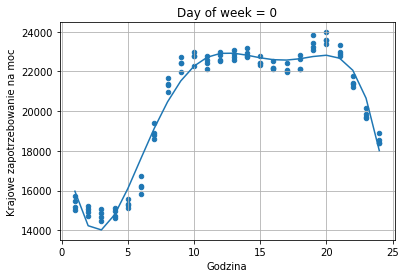

[-9.51772728e-02  6.17008966e+00 -1.46568872e+02  1.49657440e+03
 -5.29053654e+03  1.99003960e+04]
(96, 2)


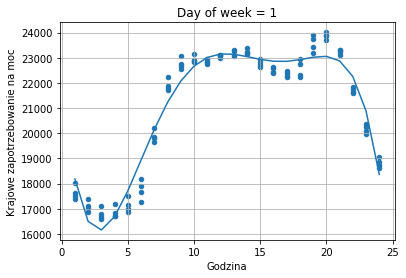

[-8.43528518e-02  5.43505860e+00 -1.28634403e+02  1.31740955e+03
 -4.81565452e+03  2.18021898e+04]
(96, 2)


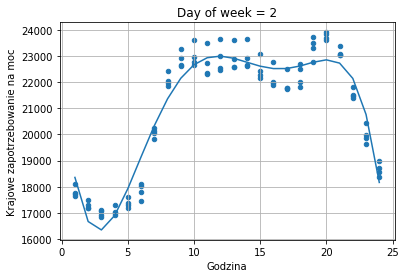

[-8.90020366e-02  5.69693666e+00 -1.33430694e+02  1.34777213e+03
 -4.87652548e+03  2.20120193e+04]
(96, 2)


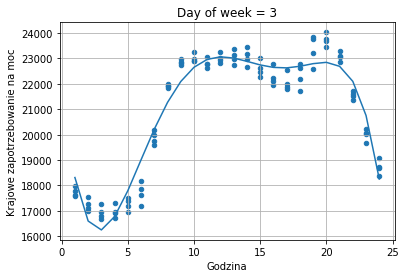

[-8.59978858e-02  5.53947530e+00 -1.30857786e+02  1.33570196e+03
 -4.88398998e+03  2.19871565e+04]
(120, 2)


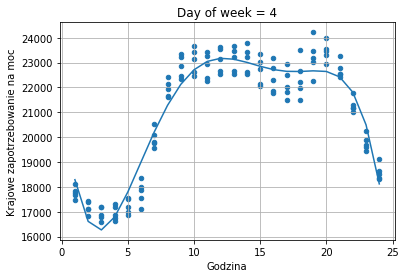

[-8.13782964e-02  5.28236019e+00 -1.25976021e+02  1.29779692e+03
 -4.76551107e+03  2.18751417e+04]
(120, 2)


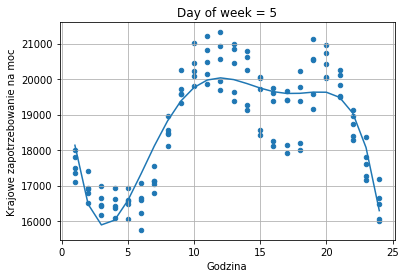

[-6.23679857e-02  4.06695537e+00 -9.78700150e+01  1.03192035e+03
 -4.13219885e+03  2.13306456e+04]
(119, 2)


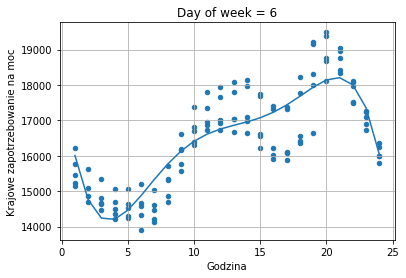

[-4.32771266e-02  2.74558358e+00 -6.47038340e+01  6.86344870e+02
 -2.89251536e+03  1.82766899e+04]


In [41]:
coeffs: List[np.ndarray] = []
for day in range(7):
    data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc"]].loc[df_zapotrzebowanie["Dzień tygodnia"] == day]
    print(data.shape)
    x = data["Godzina"]
    data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
    plt.title(f"Day of week = {day}")
    coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 5)  # Degree
    p = np.poly1d(coef)
    x = np.sort(x.drop_duplicates().to_numpy())
    plt.plot(x, p(x))
    plt.show()
    print(coef)
    coeffs.append(coef)

### First prior - normal distribution

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/model1.stan to exe file /home/ProjektDataAnalytics/model1
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/model1
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


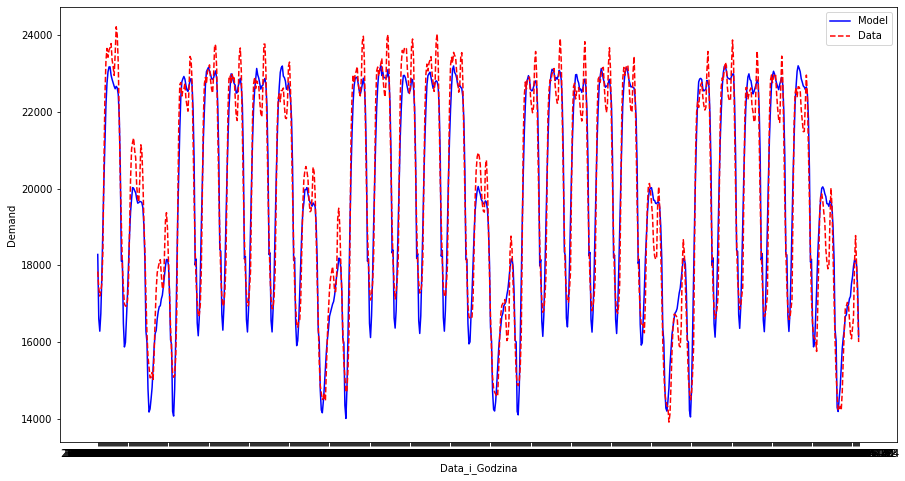

RMSE = 655.6353819439904


In [42]:
model_ppc=CmdStanModel(stan_file='model1.stan')
ppc = model_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    coeffs=coeffs
    ))
df_ppc = ppc.draws_pd()
df_ppc_mean = df_ppc.mean()[[f"demand[{i}]" for i in range(1, 744)]]
plt.figure(figsize=(15, 8))
plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
plt.xlabel("Data_i_Godzina")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.show()
print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


nu = 1


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


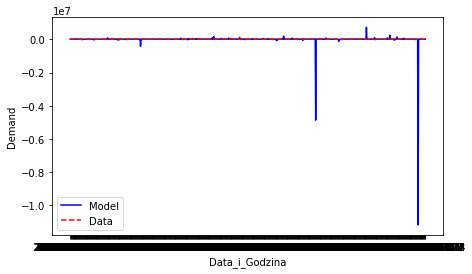

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 450090.8081787301
nu = 2


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


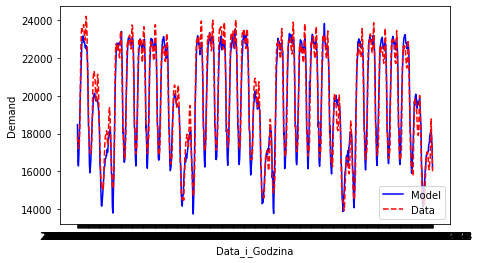

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 672.2573065570429
nu = 3


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


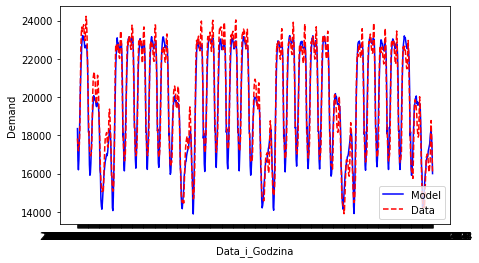

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 655.4088496931164
nu = 5


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing


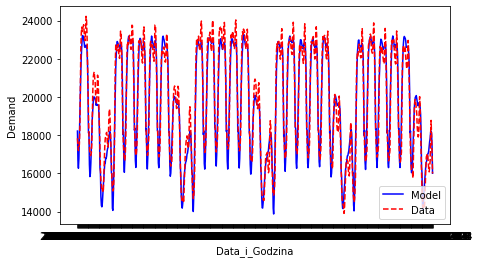

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 655.6281556788081
nu = 10


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


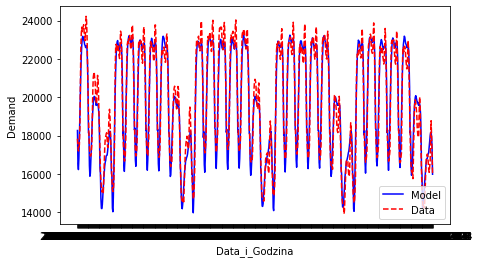

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 654.855869545388
nu = 100


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


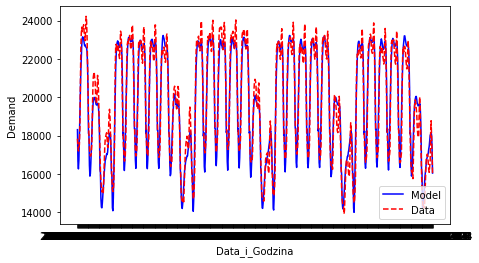

RMSE = 654.5222590222336


In [45]:
model_ppc2=CmdStanModel(stan_file='model2.stan')
for nu in [1, 2, 3, 5, 10, 100]:
    print(f"nu = {nu}")
    ppc2 = model_ppc2.sample(show_progress=False, data=dict(
        N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, nu=nu, 
        coeffs=coeffs
        ))
    df_ppc2 = ppc2.draws_pd()
    df_ppc_mean2 = df_ppc2.mean()[[f"demand[{i}]" for i in range(1, 744)]]
    plt.figure(figsize=(7, 4))
    plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean2, "b-",
            df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
    plt.xlabel("Data_i_Godzina")
    plt.ylabel("Demand")
    plt.legend(["Model", "Data"])
    plt.show()
    print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean2.values, squared=False)}')

Through experiments, it was determined that the best results (smallest value of RMSE) are achieved with nu = 5.

### Temperature's influence on the load

In [76]:
data2 = df_zapotrzebowanie[["Data_i_Godzina", "Krajowe zapotrzebowanie na moc"]]
# data2 = data2[data2["Godzina"].between(11, 21)]
data2.insert(len(data2.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == df_zapotrzebowanie.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data2))
    ])
data2

,Data_i_Godzina,Krajowe zapotrzebowanie na moc,Temperatura
0,2019-03-01 00:00:00,17834.413,3.0
1,2019-03-01 01:00:00,17408.938,2.5
2,2019-03-01 02:00:00,17195.600,1.9
3,2019-03-01 03:00:00,17304.163,1.5
4,2019-03-01 04:00:00,17533.250,1.2
...,...,...,...
738,2019-03-31 19:00:00,18097.938,8.2
739,2019-03-31 20:00:00,18774.000,7.2
740,2019-03-31 21:00:00,17979.813,6.2
741,2019-03-31 22:00:00,17091.150,5.3


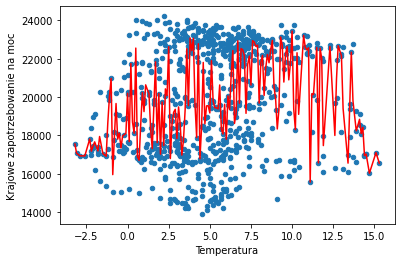

In [77]:
data2.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter")
plt.plot(sorted(data2["Temperatura"].unique()), data2.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.show()